# Notebook dedicated to EDA (exploratory data analysis)

## Preparations

### Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from collections import defaultdict
sns.set(style="whitegrid")
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Data import

In [2]:
movies = pd.read_csv('../data/movies.csv')
ratings = pd.read_csv('../data/ratings.csv')
tags = pd.read_csv('../data/tags.csv')

## Data exploration

### Basic information about the dataset used

In [3]:
print("Ratings dataset:")
print(ratings.head())
print("\nMovies dataset:")
print(movies.head())
print("\nTags dataset:")
print(tags.head())

print(f"\nNumber of ratings: {len(ratings)}")
print(f"Number of unique users: {ratings.userId.nunique()}")
print(f"Number of unique movies: {movies.movieId.nunique()}")
print(f"Time frame for ratings: {pd.to_datetime(ratings.timestamp, unit='s').min()} - {pd.to_datetime(ratings.timestamp, unit='s').max()}")

Ratings dataset:
   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858

Movies dataset:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Tags dataset:
   userId  movieId          tag   timestamp
0      22    26479  Kevin Kline  1583038886
1      22    79592     misogyny  1581476

### Distribution, mean, and median of ratings

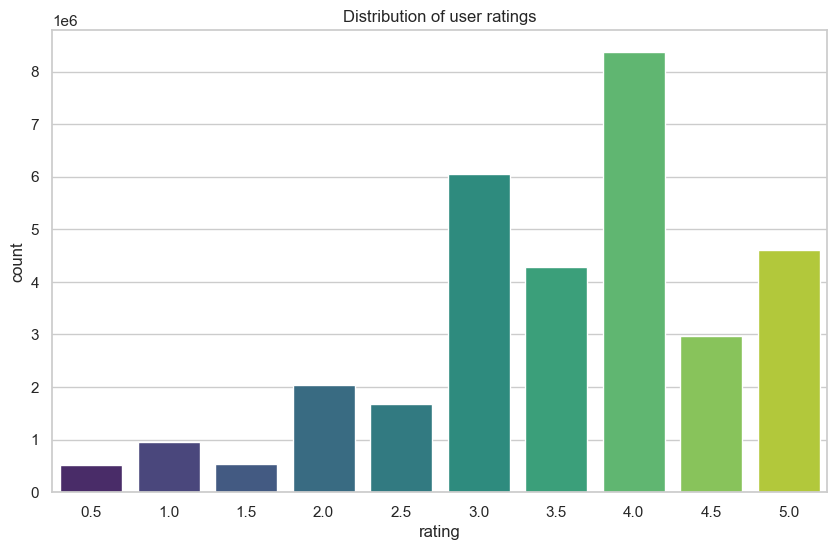

Average rating: 3.54
Median rating: 3.5


In [4]:
plt.figure(figsize=(10,6))
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribution of user ratings')
plt.show()

print(f"Average rating: {ratings.rating.mean():.2f}")
print(f"Median rating: {ratings.rating.median()}")

### Analysis of user activity

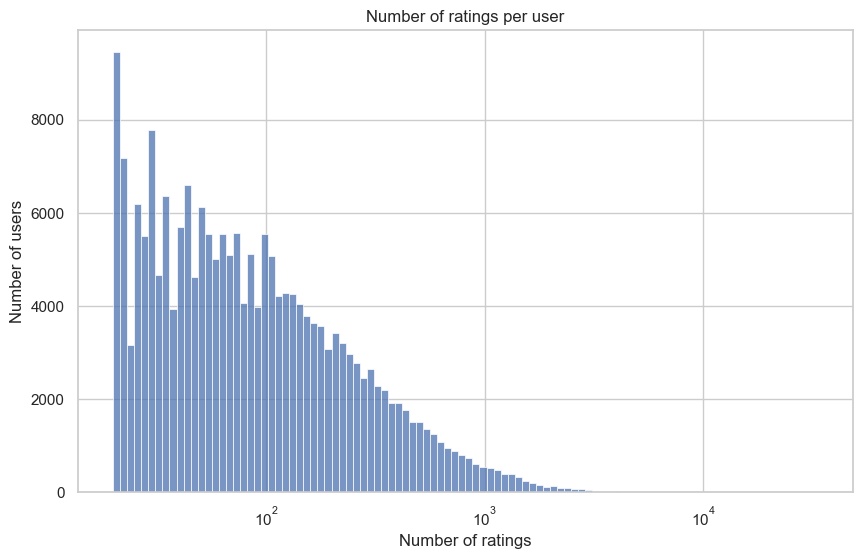

In [5]:
user_ratings = ratings['userId'].value_counts()
plt.figure(figsize=(10,6))
sns.histplot(user_ratings, bins=100, log_scale=(True, False))
plt.title('Number of ratings per user')
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show()

In addition to the above chart, the following values were also determined: average number of ratings per user, median, maximum and minimum values.

In [6]:
print(f"Average number of ratings per user: {user_ratings.mean():.2f}")
print(f"Median number of ratings per user: {user_ratings.median():.0f}")
print(f"Most ratings per user: {user_ratings.max()}")
print(f"Fewest ratings per user: {user_ratings.min()}")

Average number of ratings per user: 159.25
Median number of ratings per user: 73
Most ratings per user: 33332
Fewest ratings per user: 20


### Analysis of movie popularity
The popularity of a movie is understood by the number of ratings it receives.

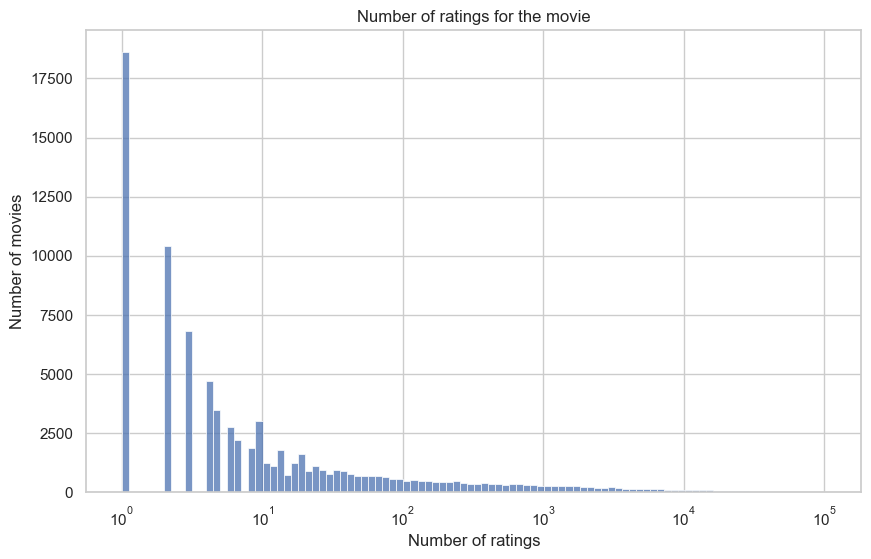

In [7]:
movie_ratings = ratings['movieId'].value_counts().reset_index()
movie_ratings.columns = ['movieId', 'count']
movie_stats = movie_ratings.merge(movies, on='movieId')

plt.figure(figsize=(10,6))
sns.histplot(movie_ratings['count'], bins=100, log_scale=(True, False))
plt.title('Number of ratings for the movie')
plt.xlabel('Number of ratings')
plt.ylabel('Number of movies')
plt.show()

Below are the 10 most popular films in our database.

In [8]:
top_movies = movie_stats.sort_values('count', ascending=False).head(10)
print("\nTop 10 most popular movies by number of ratings:")
print(top_movies[['title', 'count']])


Top 10 most popular movies by number of ratings:
                                               title   count
0                   Shawshank Redemption, The (1994)  102929
1                                Forrest Gump (1994)  100296
2                                Pulp Fiction (1994)   98409
3                                 Matrix, The (1999)   93808
4                   Silence of the Lambs, The (1991)   90330
5          Star Wars: Episode IV - A New Hope (1977)   85010
6                                  Fight Club (1999)   77332
7                               Jurassic Park (1993)   75233
8                            Schindler's List (1993)   73849
9  Lord of the Rings: The Fellowship of the Ring,...   73122


### Analysis of movie genres

Initially, the genres of each film were considered as completely separate categories and were not weighted according to the number of genres to which a given film belonged.
> Example: If film A belongs to categories a, b, and c, then when counting the film's membership in a given category, we always add **+1**.

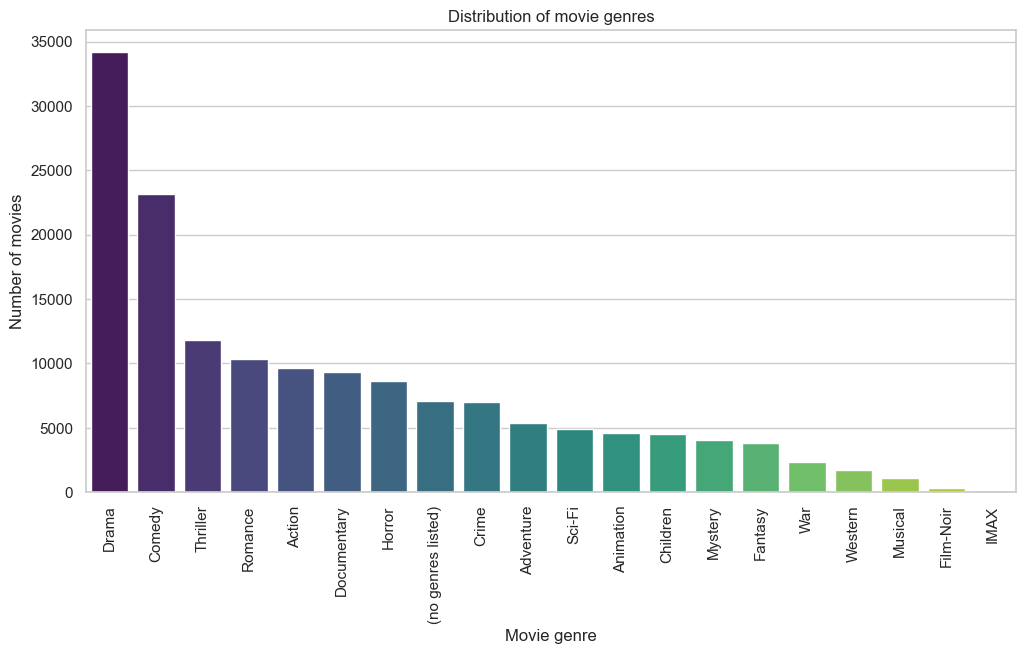

In [9]:
# Separating movie genres into separate categories
genres = defaultdict(int)
for movie in movies['genres']:
    for genre in movie.split('|'):
        genres[genre] += 1

genres_df = pd.DataFrame.from_dict(genres, orient='index', columns=['count']).sort_values('count', ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=genres_df.index, y=genres_df['count'], palette='viridis')
plt.xticks(rotation=90)
plt.title('Distribution of movie genres')
plt.xlabel('Movie genre')
plt.ylabel('Number of movies')
plt.show()

The median, maximum value, and average number of movie genres per movie were determined.

In [10]:
movies['num_genres'] = movies['genres'].apply(lambda x: len(x.split('|')))
print(f"Median number of movie genres per movie: {movies['num_genres'].median()}")
print(f"Max number of movie genres per movie: {movies['num_genres'].max()}")
print(f"Average number of movie genres per movie: {movies['num_genres'].mean():.2f}")

Median number of movie genres per movie: 1.0
Max number of movie genres per movie: 10
Average number of movie genres per movie: 1.76


Next, we will present the relationship between average rating and the number of genres assigned to the film.

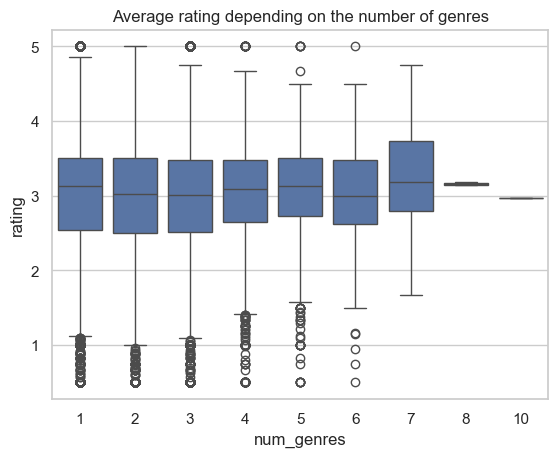

In [11]:
genre_count_analysis = movies.merge(ratings.groupby('movieId')['rating'].mean().reset_index(), on='movieId')
sns.boxplot(x='num_genres', y='rating', data=genre_count_analysis)
plt.title('Average rating depending on the number of genres')
plt.show()

In the second variant, we assumed that a film's genre affiliation would be divided by the number of all genres to which it belongs. In this case, of course, it makes no sense to examine the average, maximum, and median number of film genres, because they are all 1.
> Example: If movie A belongs to categories a, b, and c, then when counting the movie's membership in a given category, we add **1/3**.

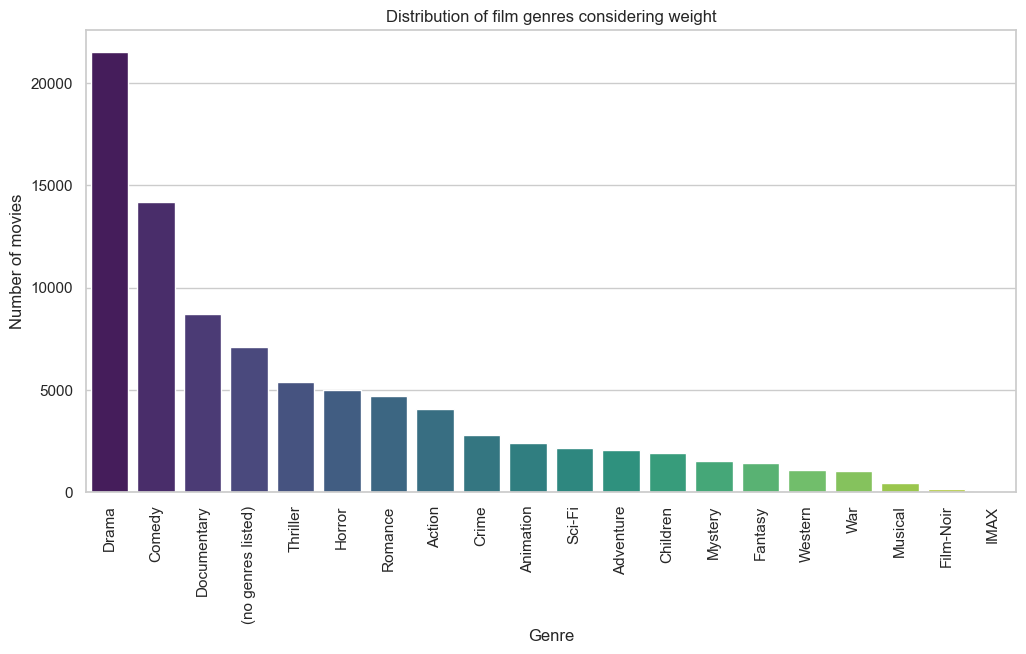

In [13]:
genres_with_weights = defaultdict(float)
for movie in movies['genres']:
    weight = 1 / len(movie.split('|'))
    for genre in movie.split('|'):
        genres_with_weights[genre] += weight

genres_with_weights_df = pd.DataFrame.from_dict(genres_with_weights, orient='index', columns=['count']).sort_values('count', ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=genres_with_weights_df.index, y=genres_with_weights_df['count'], palette='viridis')
plt.xticks(rotation=90)
plt.title('Distribution of film genres considering weight')
plt.xlabel('Genre')
plt.ylabel('Number of movies')
plt.show()

### Investigating the sparsity of user-movie matrix

In [14]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
sparsity = (1 - len(ratings)/(n_users * n_movies)) * 100
print(f"\nSparsity: {sparsity:.2f}%")


Sparsity: 99.81%


### Qualitative analysis of movies

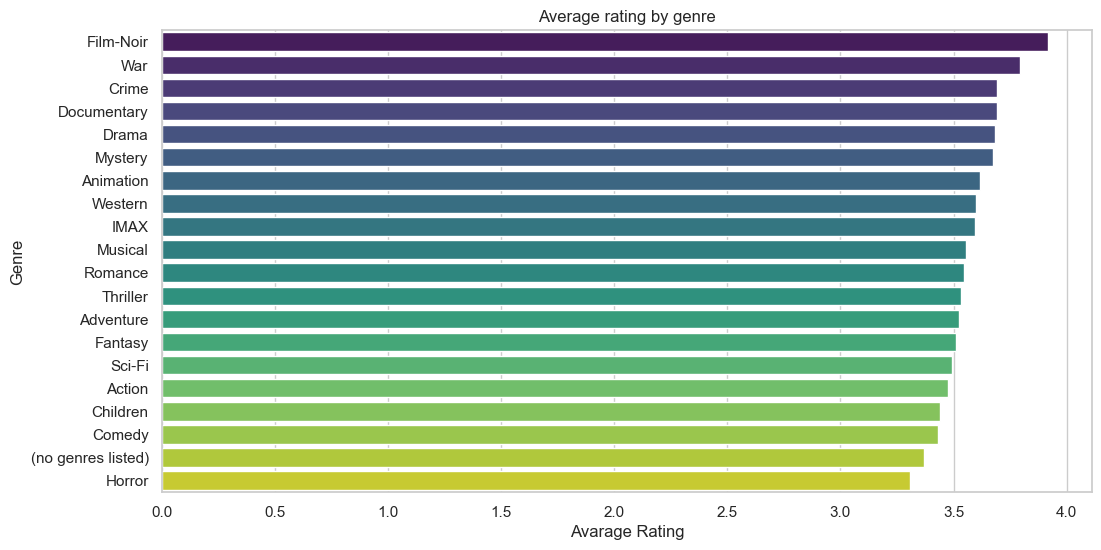

In [15]:
# Combining rating data with movie metadata
merged = ratings.merge(movies, on='movieId')

# Average rating for each genre
genres_ratings = []
for genre in genres_df.index:
    mask = merged['genres'].str.contains(genre)
    avg_rating = merged.loc[mask, 'rating'].mean()
    genres_ratings.append((genre, avg_rating))

genres_ratings_df = pd.DataFrame(genres_ratings, columns=['Genre', 'Avg Rating']).sort_values('Avg Rating', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='Avg Rating', y='Genre', data=genres_ratings_df, palette='viridis')
plt.title('Average rating by genre')
plt.xlabel('Avarage Rating')
plt.ylabel('Genre')
plt.show()

### Analysis of tags for movies

At the beginning, general statistics on tags will be provided.

In [17]:
tag_counts = tags['tag'].str.lower().value_counts()
print(f"\nTotal number of tags: {len(tags)}")
print(f"Number of unique tags: {len(tag_counts)}")
print(f"Average tag usage: {tag_counts.mean():.2f}")
print(f"Median tag usage: {tag_counts.median()}")
print(f"Average number of non-unique tags per movie: {tags['movieId'].value_counts().mean():.2f}")
print(f"Median number of non-unique tags per movie: {tags['movieId'].value_counts().median()}")
print(f"Average number of unique tags per movie: {tags.groupby('movieId')['tag'].nunique().mean():.2f}")
print(f"Median number of unique tags per movie: {tags.groupby('movieId')['tag'].nunique().median()}")


Total number of tags: 2000072
Number of unique tags: 132171
Average tag usage: 15.13
Median tag usage: 1.0
Average number of non-unique tags per movie: 38.97
Median number of non-unique tags per movie: 5.0
Average number of unique tags per movie: 21.18
Median number of unique tags per movie: 5.0


Below are the 20 most frequently used tags

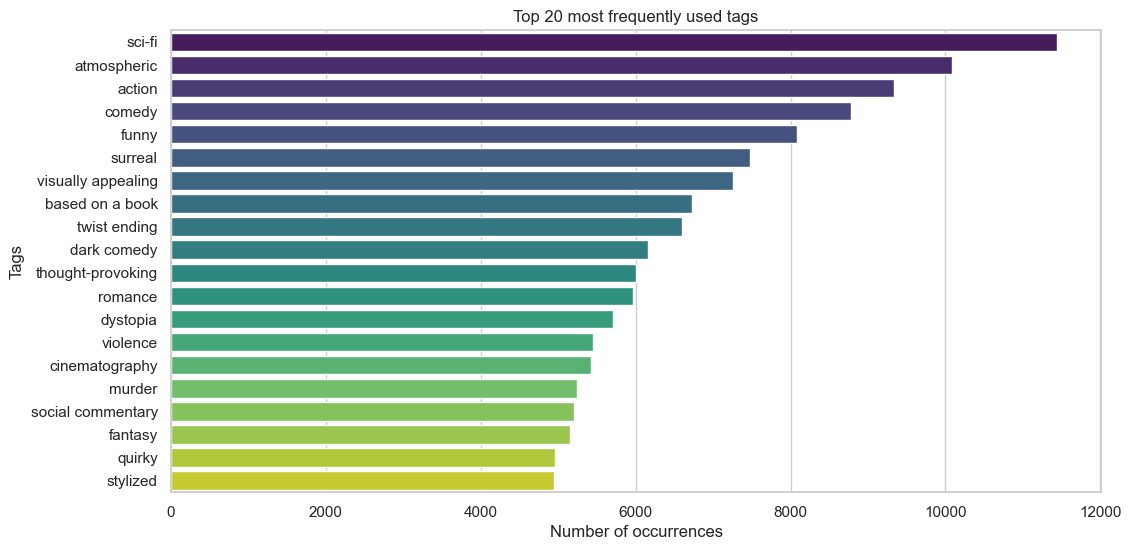

In [18]:
tag_counts = tag_counts.head(20)
plt.figure(figsize=(12,6))
sns.barplot(y=tag_counts.index, x=tag_counts.values, palette="viridis")
plt.title('Top 20 most frequently used tags')
plt.xlabel('Number of occurrences')
plt.ylabel('Tags')
plt.show()

For the tags displayed above, an average rating for the tagged movie will be determined.

In [19]:
merged_tags = ratings.merge(tags, on=['userId', 'movieId'])
tag_analysis = merged_tags.groupby('tag')['rating'].agg(['mean', 'count'])
print(tag_analysis.sort_values('count', ascending=False).head(20))

                        mean  count
tag                                
sci-fi              3.961934  10508
atmospheric         4.213926   9321
action              3.866782   8077
comedy              3.928873   7571
funny               4.056887   7260
surreal             4.209636   6974
visually appealing  4.159882   6927
twist ending        4.242007   6349
thought-provoking   4.377865   5846
dark comedy         4.190826   5657
based on a book     3.831044   5534
dystopia            3.915410   5373
cinematography      4.190273   5161
social commentary   4.141477   4969
romance             3.890277   4803
stylized            4.139270   4739
psychology          4.283498   4642
fantasy             3.951257   4575
quirky              4.157906   4490
dark                4.134053   4308


### Exploring movie title texts

The data set does not include the production dates of the films, so they will be taken from the titles and presented in the chart.

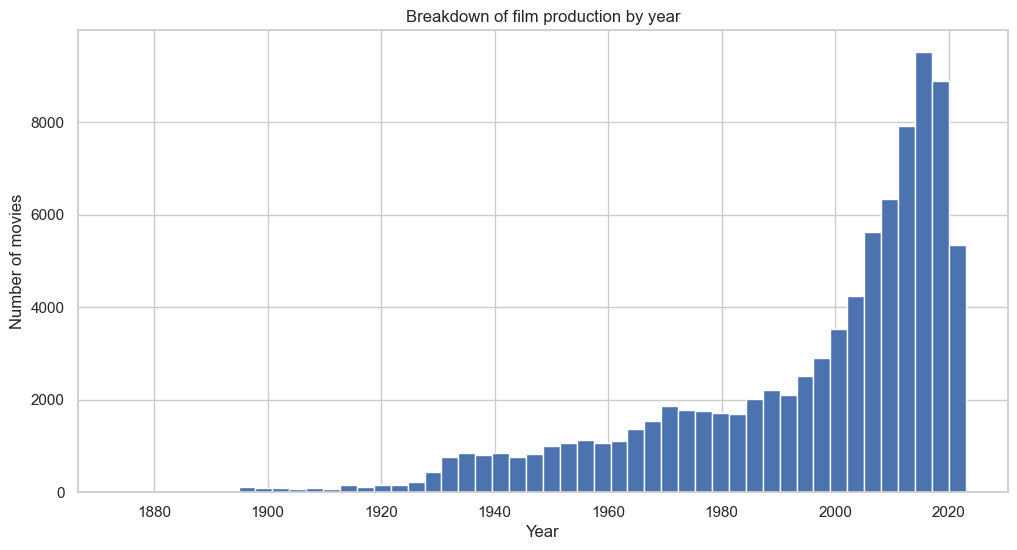

In [20]:
# Extracting the year from titles
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)

# Breakdown of film production by year
plt.figure(figsize=(12,6))
movies['year'].hist(bins=50)
plt.title('Breakdown of film production by year')
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.show()

Next, the titles of the films will be analyzed, more specifically the words they contain.

Number of all words in movie titles: 282955
Number of all unique words in movie titles: 56378


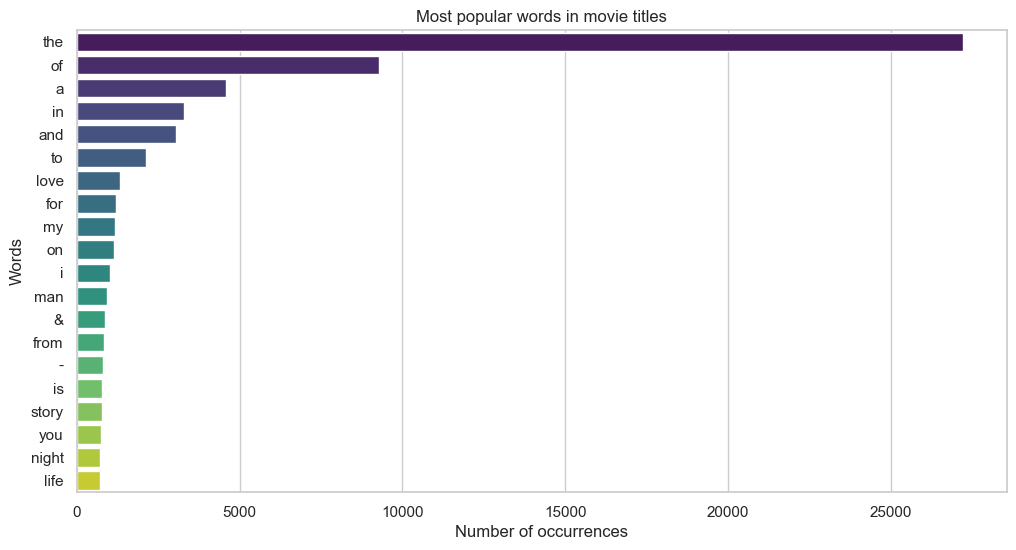

In [21]:
# Most popular words in movie titles
title_words = ' '.join(movies['title'].str.replace(r'\(\d{4}\)', '', regex=True))
print(f"Number of all words in movie titles: {len(title_words.split())}")
title_words = title_words.lower()
title_words = title_words.split()
title_word_counts = defaultdict(int)
for word in title_words:
    title_word_counts[word] += 1
print(f"Number of all unique words in movie titles: {len(title_word_counts.keys())}")

plt.figure(figsize=(12,6))
word_counts_df = pd.DataFrame.from_dict(title_word_counts, orient='index', columns=['count']).sort_values('count', ascending=False).head(20)
sns.barplot(x=word_counts_df['count'], y=word_counts_df.index, palette='viridis')
plt.title('Most popular words in movie titles')
plt.xlabel('Number of occurrences')
plt.ylabel('Words')
plt.show()

The most popular words turned out to be those without much substantive value. It would be difficult to build a recommendation system based on them, so we decided to remove words such as "and", "the", "of", etc. from the titles. We also decided to use lemmatization to reduce the number of non-unique words.
<br>
<br> **Example:**
<br> Before: "running", "ran", "runs" -> 3 different words
<br> After: "running", "ran", "runs" -> "run"
<br>
<br>
The results of our actions are presented below.

Total number of words in movie titles after cleaning: 195781
Number of all unique words in movie titles after cleaning: 39515


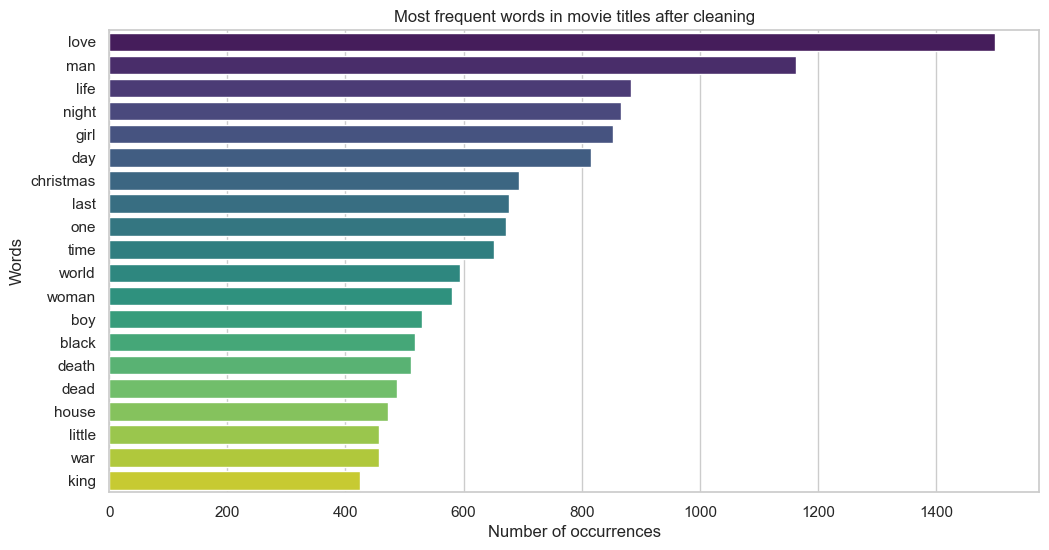

In [23]:
# Most popular words in movie titles after cleaning
wc_module_path = os.path.abspath(os.path.join('..', 'src'))
if wc_module_path not in sys.path:
    sys.path.append(wc_module_path)
from wordcleaner import TitleCleaner
cleaner = TitleCleaner()

movies['cleaned_title'] = movies['title'].apply(lambda x: cleaner.clean_title(x))
cleaned_title_words = ' '.join(movies['cleaned_title'])
print(f"Total number of words in movie titles after cleaning: {len(cleaned_title_words.split())}")
cleaned_title_word_counts = defaultdict(int)
for word in cleaned_title_words.split():
    cleaned_title_word_counts[word] += 1
print(f"Number of all unique words in movie titles after cleaning: {len(cleaned_title_word_counts.keys())}")

plt.figure(figsize=(12,6))
cleaned_word_counts_df = pd.DataFrame.from_dict(cleaned_title_word_counts, orient='index', columns=['count']).sort_values('count', ascending=False).head(20)
sns.barplot(x=cleaned_word_counts_df['count'], y=cleaned_word_counts_df.index, palette='viridis')
plt.title('Most frequent words in movie titles after cleaning')
plt.xlabel('Number of occurrences')
plt.ylabel('Words')
plt.show()

# Saving cleaned titles to a CSV file
movies[['movieId', 'cleaned_title']].to_csv('../data/clean_titles.csv', index=False)

### Data quality for the content-based method

In [24]:
# Missing data in metadata
print("Missing data in movies.csv:")
print(movies.isnull().sum())

# Genres
print(f"Number of movies without genres: {movies[movies['genres'] == '(no genres listed)'].shape[0]}")

# Tags
movies_with_tags = tags['movieId'].unique()
movies['has_tags'] = movies['movieId'].isin(movies_with_tags)
no_tag_count = len(movies) - movies['has_tags'].sum()
print(f"Movies without any tags: {no_tag_count} ({(no_tag_count/len(movies))*100:.2f}%)")


Missing data in movies.csv:
movieId            0
title              0
genres             0
num_genres         0
year             615
cleaned_title      0
dtype: int64
Number of movies without genres: 7080
Movies without any tags: 36262 (41.40%)
